In [ ]:
import sys
import os
sys.path.append(os.path.abspath("D:\\Python\\commodity_futures_price"))

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload
from model.savvy_sh import SavvySh

### Read the Files of Commodities

In [ ]:
df_dict = {}
valid_dates = pd.date_range(start="2011-01-01", end="2024-12-31", freq="B")
# Read each file in below folder
path = "../data/raw/"
files = os.listdir(path)
for file in files:
    if file.endswith(".csv"):
        # Exclude LB due to data correctness issue
        if file.startswith("LB"):
            continue
        df = pd.read_csv(os.path.join(path, file), index_col=0, parse_dates=True)
        df["Return"] = df.iloc[:, 0:1].apply(lambda x: np.log(x.shift(-1) / x))
        df = df.dropna()

        non_positive_LA = df[(df[df.columns[0]] <= 0) | (df['Volatility'] <= 0)]
        df = df.drop(index=non_positive_LA.index)

        df_dict[file[:-4]] = df
        valid_dates = valid_dates.intersection(df.index)
for name, df in df_dict.items():
    df_dict[name] = df[df.index.isin(valid_dates)]

In [7]:
dates_len = len(valid_dates)
train_size = 3 * 12
test_size = 1

start_end_list = []
start = 0
while(start < dates_len - train_size - test_size):
    end = start + train_size + test_size - 1
    start_end_list.append((start, end))
    start = start + test_size

# print(start_end_list)

### Rolling Window Prediction

### OLS

In [ ]:
ols_mse_by_time = []
for start, end in start_end_list:
    ols_mse_by_df = []
    for name, df in df_dict.items():
        train = df.iloc[start:end - test_size + 1]
        train_X, train_y = train.drop(columns=["Basis_Momentum", "Return"]), train["Return"]
        test_X, test_y = df.iloc[end - test_size + 1:end - test_size + 2].drop(columns=["Basis_Momentum", "Return"]), df.iloc[end - test_size + 1:end - test_size + 2]["Return"]

        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)

        ols = LinearRegression()
        ols.fit(train_X, train_y)
        ols_predict = ols.predict(test_X)
        # print(name, df.index[end - test_size], ols_predict)
        mse = mean_squared_error(test_y, ols_predict)
        ols_mse_by_df.append(mse)

    ols_mse_by_time.append(np.mean(ols_mse_by_df))

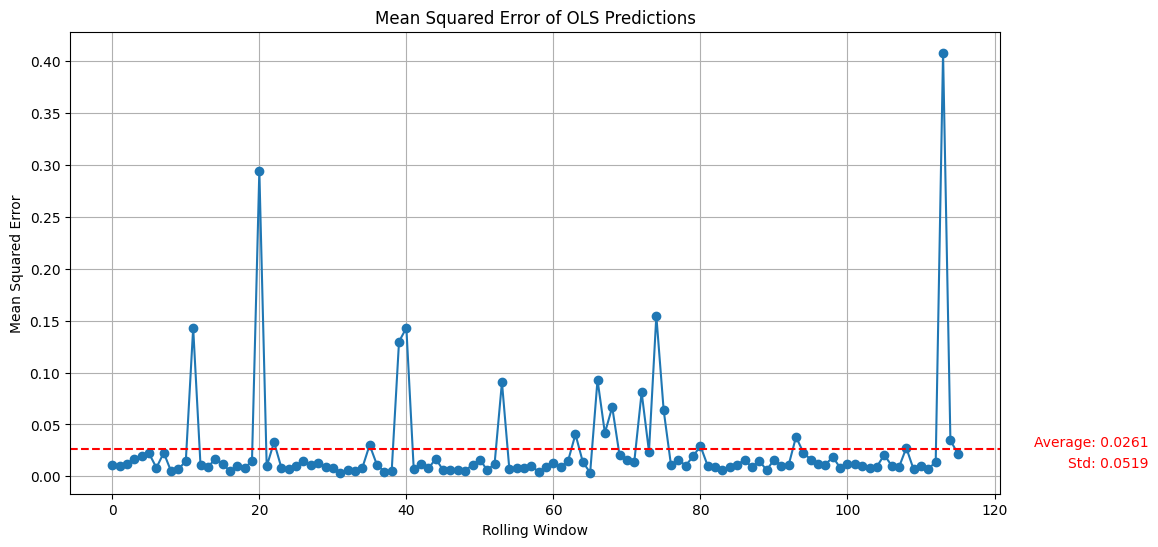

In [42]:
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(ols_mse_by_time, marker='o')
plt.axhline(y=np.mean(ols_mse_by_time), color='r', linestyle='--')
plt.text(len(ols_mse_by_time) + 25, np.mean(ols_mse_by_time), f"Average: {np.mean(ols_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(ols_mse_by_time) + 25, np.mean(ols_mse_by_time) - 0.02, f"Std: {np.std(ols_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of OLS Predictions")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### Stein

In [ ]:
stein_mse_by_time = []
for start, end in start_end_list:
    stein_mse_by_df = []
    for name, df in df_dict.items():
        train = df.iloc[start:end - test_size + 1]
        train_X, train_y = train.drop(columns=["Basis_Momentum", "Return"]), train["Return"]
        test_X, test_y = df.iloc[end - test_size + 1:end - test_size + 2].drop(columns=["Basis_Momentum", "Return"]), df.iloc[end - test_size + 1:end - test_size + 2]["Return"]

        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)

        model_mult = SavvySh(model_class="Multiplicative")
        model_mult.fit(train_X, train_y)
        stein_predict = model_mult.predict(test_X)["St"]
        # print(name, df.index[end - test_size], stein_predict)
        stein_mse = mean_squared_error(test_y, stein_predict)
        stein_mse_by_df.append(stein_mse)

    stein_mse_by_time.append(np.mean(stein_mse_by_df))

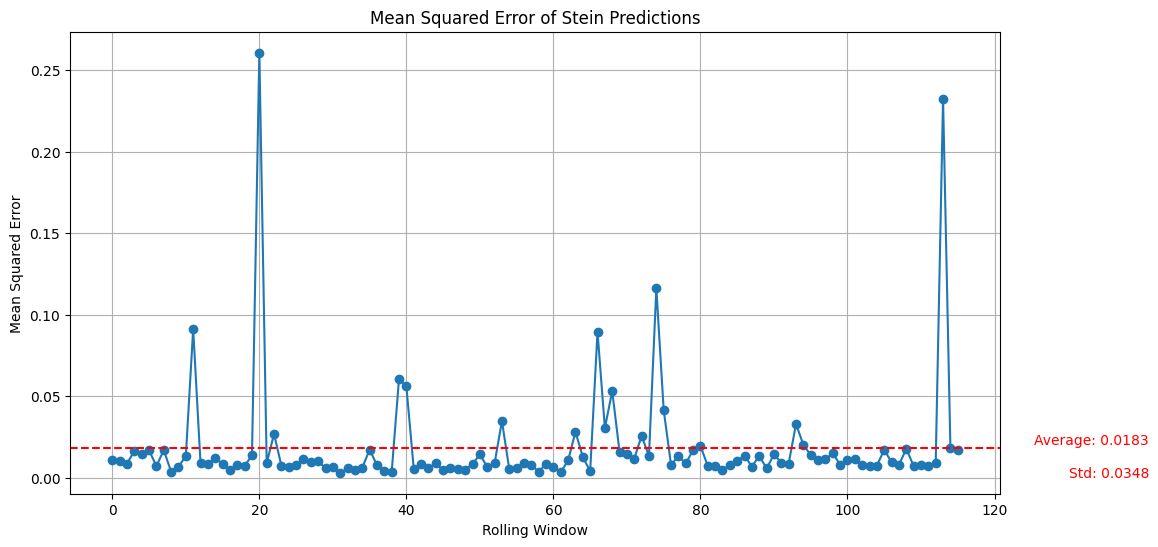

In [44]:
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(stein_mse_by_time, marker='o')
plt.axhline(y=np.mean(stein_mse_by_time), color='r', linestyle='--')
plt.text(len(stein_mse_by_time) + 25, np.mean(stein_mse_by_time), f"Average: {np.mean(stein_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(stein_mse_by_time) + 25, np.mean(stein_mse_by_time) - 0.02, f"Std: {np.std(stein_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Stein Predictions")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### DSh

In [ ]:
DSh_mse_by_time = []
for start, end in start_end_list:
    DSh_mse_by_df = []
    for name, df in df_dict.items():
        train = df.iloc[start:end - test_size + 1]
        train_X, train_y = train.drop(columns=["Basis_Momentum", "Return"]), train["Return"]
        test = df.iloc[end - test_size + 1:end - test_size + 2]
        test_X, test_y = test.drop(columns=["Basis_Momentum", "Return"]), test["Return"]

        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)

        model_mult = SavvySh(model_class="Multiplicative")
        model_mult.fit(train_X, train_y)
        DSh_predict = model_mult.predict(test_X)["DSh"]
        # print(name, df.index[end - test_size], DSh_predict)
        DSh_mse = mean_squared_error(test_y, DSh_predict)
        DSh_mse_by_df.append(DSh_mse)

    DSh_mse_by_time.append(np.mean(DSh_mse_by_df))

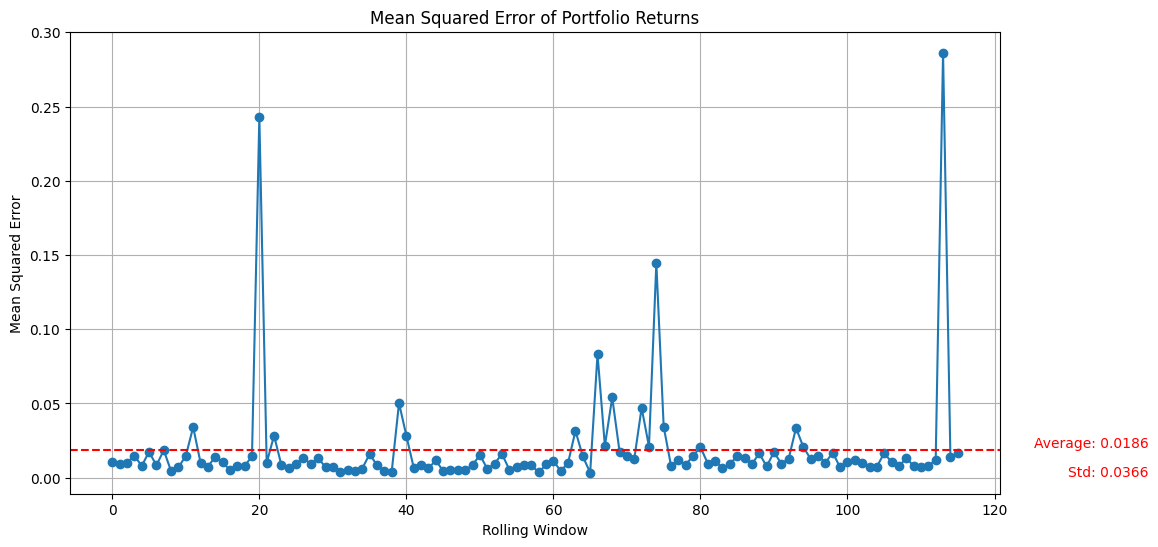

In [47]:
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(DSh_mse_by_time, marker='o')
plt.axhline(y=np.mean(DSh_mse_by_time), color='r', linestyle='--')
plt.text(len(DSh_mse_by_time) + 25, np.mean(DSh_mse_by_time), f"Average: {np.mean(DSh_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(DSh_mse_by_time) + 25, np.mean(DSh_mse_by_time) - 0.02, f"Std: {np.std(DSh_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Portfolio Returns")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()